## Case 1 - Deterministic
## Case 2 - DRO opt w/o $\gamma$
## Case 3 - DRO opt w $\gamma$
## Case 4 - DRO opt w DRJCC
## Case 5 - DRO opt DRJCC with ESS reserve
## Case 6 - DRO opt DRJCC with ESS reserve but without revenue
## Case 7 - IGDT - DRO opt DRJCC
### Author: Junhyeok Kim

In [1]:
# Import the library

import os
import pandas as pd
import numpy as np
import sys
import time

import matplotlib.pyplot as plt
np.set_printoptions(formatter={'float': '{: 0.6f}'.format})

In [2]:
# Define the Variables
BASE_DIR = os.getcwd()
os.chdir("../")
path = os.getcwd() 
sys.path.append(path) # 폴더 한 단계 위에서 file import 하기 위해서 sys path 설정
sys.path.append(f"{path}/src")
sys.path.append(f"{path}/src/Data_Generation")

from rts_data import generate_wind, generate_gen_dict
from aggregator import aggregator
from gurobiMILP import gurobi_MILP
from draw_fig import Single_Case_Plot

In [3]:
### Parameters
DRO_param = {'eps_joint_cvar' : 0.05}
DRO_param['theta'] = 0.05

# Vector for Bonferroni approximation
rho_vectorC = np.linspace(0, 0.0025, 26)

# Number of individual runs (number of coupled datasets in the numerical study)

IR_max = 100
IR_sim = 100

# Number of out of sample data for each individual run (N') for testing
# dataset

OOS_max = 200
OOS_sim = 100

# Number of maximum sample size (N)

N_max = 1000

# Number of sample data in training dataset (N)

N = 100;


# Total number of data 

n_total_scen = IR_max * (N_max + OOS_max)

In [4]:
# Define the Parameters

# case_dict: Generate various scenario
# res_var: Define the WT and PV as variables [True] or parameters [False]
# case:
    # case 1 : w/o uncertainty
    # case 2 : w uncertainty with DRO
    #UNIT_TIME: 1 -> 1 hour
    
case_dict = {'case':6, 'UNIT_TIME': 1, 'bid_type':'deterministic', 'n_total_scen': n_total_scen, 'N_max': N_max, 'OOS_max':OOS_max,
             'IR_max': IR_max, 'N': N, 'OOS_sim': OOS_sim, 'divide_factor': 2}

case_dict['date'] = '20220911'

nTimeslot = int(24 / case_dict['UNIT_TIME'])
char_ess = {'initSOC':0.5, 'termSOC':0.5, 'minSOC':0.2, 'maxSOC':0.8, 'efficiency':0.95}


model_dict = {'nVPP':1, 'path': path, 'N_PIECE': 10, 'nTimeslot': nTimeslot}

# Once, set te PV, WT, SMP uncertainties identically in each time (PV: 5%, WT: 10%, SMP: 10%)
uncertainty_dict = {'pv': np.ones(nTimeslot)*0.10 , 'wt': np.ones(nTimeslot)*0.10, 'smp':np.ones(nTimeslot)*0.10}


if case_dict['case']==7:
    
    model_dict['uncertainty'] = uncertainty_dict
    case_dict['bid_type'] = 'risk-averse'
    
elif case_dict['case'] == 1:
    
    uncertainty_dict = {'pv': np.zeros(nTimeslot), 'wt': np.zeros(nTimeslot), 'smp':np.zeros(nTimeslot)}
    model_dict['uncertainty'] = uncertainty_dict
    

In [5]:
# Set Up VPP  #Unit: kW

vpp_list = []
for i in range(model_dict['nVPP']):
    nGen_dict = {'WT':4,'PV':2, 'ESS':1, 'DG':2}
    wt_list = [800, 700, 900, 1000]
    pv_list = [500, 750, 500, 700]
    ess_list = [300]
    capacity_list = [1500]
    dg_list = [300, 400, 900]
    max_list = [wt_list, pv_list, ess_list, capacity_list, dg_list]
    
    dg_dict_list = []
    for j in range(nGen_dict['DG']):
        dg_dict_list.append(generate_gen_dict(j,dg_list[j], model_dict))
    model_dict['dg_dict_list'] = dg_dict_list
    
    agg_dict = {'name': f'cvpp{i+1}', 'code': f'xds{i+1}', 'gen':nGen_dict}
    vpp_list.append(aggregator(agg_dict, char_ess, model_dict, case_dict))
    vpp_list[i].set_der_power(max_list)
    vpp_list[i].set_smp_data(case_dict['date'])
    
vpp_list[0].get_res_table()

Error
'aggregator' object has no attribute 'wt_uncert'
Aggregator set_res_table method
Uncertainty does not exist


,name,type,number,min_power,max_power,capacity
0,WT1_cvpp1,WT,1,0.0,800,NaN
1,WT2_cvpp1,WT,2,0.0,700,NaN
2,WT3_cvpp1,WT,3,0.0,900,NaN
3,WT4_cvpp1,WT,4,0.0,1000,NaN
4,PV5_cvpp1,PV,5,0.0,500,NaN
5,PV6_cvpp1,PV,6,0.0,750,NaN
6,ESS7_cvpp1,ESS,7,-300.0,300,1500.0
7,DG8_cvpp1,DG,8,30.0,300,NaN
8,DG9_cvpp1,DG,9,40.0,400,NaN


# Gurobi Optimization Model

# Set the parameter for DRO
case_dict['theta'] = [DRO_param['theta']] * nTimeslot
#case_dict['theta'] = np.array([0.05]*24)
# Set the parameter for DRCC
case_dict['eps'] = DRO_param['eps_joint_cvar']

# Set the parameter for IGDT
case_dict['beta'] = 0.05
case_dict['alpha_max'] = 0.2
case_dict['GRID_PIECE'] = 50

base_opt = gurobi_MILP('opt bid', vpp_list[0], model_dict, case_dict)

mip_gap = 0.0001
feas_tol = 1e-4
sol1, obj_dict1, P_dict1, U_dict1, slack_dict1 = base_opt.optimize(mip_gap, feas_tol)
base_obj = base_opt.m.objVal

In [6]:
base_obj = 4333531.764487116

In [7]:
# Gurobi Optimization Model
case_dict['case'] = 7
# Set the parameter for DRO
case_dict['theta'] = [DRO_param['theta']] * nTimeslot
#case_dict['theta'] = np.array([0.05]*24)
# Set the parameter for DRCC
case_dict['eps'] = DRO_param['eps_joint_cvar']

# Set the parameter for IGDT
case_dict['beta'] = 0.1
case_dict['alpha_max'] = 0.3
case_dict['GRID_PIECE'] = 100

opt_bid_igdt = gurobi_MILP('opt bid_igdt', vpp_list[0], model_dict, case_dict)
opt_bid_igdt.set_igdt_params(base_obj, case_dict['beta'])
mip_gap = 0.0001
feas_tol = 1e-4
sol, obj_dict, P_dict, U_dict, slack_dict = opt_bid_igdt.optimize(mip_gap, feas_tol)


Add Bid Constraint
start set_dro_obj_constriants
end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
start add_igdt_constraints
add_igdt_risk_averse_constraints sucessfully
End add_igdt_constarints
start add_igdt_constraints
add_igdt_risk_averse_constraints sucessfully
End add_igdt_constarints
Set parameter FeasibilityTol to value 0.0001
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 29793 rows, 59241 columns and 172654 nonzeros
Model fingerprint: 0xe07447a8
Model has 2 SOS constraints
Model has 5200 general constraints
Variable types: 58949 continuous, 292 integer (292 binary)
Coefficient statistic

     0     0    0.08202    0  216          -    0.08202      -     -   41s
     0     2    0.08202    0  216          -    0.08202      -     -   42s
   122    29    0.07191   18  118          -    0.07871      -   189   45s
   892   359    0.07386   36  114          -    0.07764      -   110   50s
* 1024   396             118       0.0319960    0.07764   143%   103   50s
H 1060   415                       0.0320759    0.07764   142%   101   50s
* 1675   611              81       0.0320897    0.07690   140%  94.0   53s
  1752   608    0.06847   20  275    0.03209    0.07690   140%  92.4   56s
  1762   615    0.07257   15   80    0.03209    0.07602   137%  91.9   60s
  1777   625    0.07392   31   78    0.03209    0.07587   136%  91.1   65s
H 1785   597                       0.0559627    0.07532  34.6%  90.7   67s
  1792   602    0.07033   22   40    0.05596    0.07527  34.5%  90.4   70s
H 1802   577                       0.0589336    0.07393  25.5%  89.9   72s
H 1802   547             

In [8]:
case_fig = Single_Case_Plot(vpp_list, opt_bid_igdt, model_dict, case_dict, path)

setPlotStyle()


In [9]:
# Print lhs,rhs of the igdt_constraints

lhs = 0
for t in range(24):
    lhs += opt_bid_igdt.dayahead_smp[t] * P_dict['bid'][t]
    lhs -= opt_bid_igdt.dayahead_smp[t] * slack_dict['z'][t]
    lhs -= obj_dict['obj2'][t]
    lhs -= obj_dict['obj3'][t]
    lhs -= obj_dict['dg_cost'][0][t]
    lhs -= obj_dict['dg_cost'][1][t]
    
rhs = 0

rhs = (1- opt_bid_igdt.beta) * opt_bid_igdt.base_obj
print(lhs, rhs)

3900178.588038372 3900178.588038404


In [10]:
(1-opt_bid_igdt.beta)*opt_bid_igdt.base_obj

3900178.588038404

In [11]:
obj1 = obj_dict['obj1']
print(obj1)

try:
    obj2 = obj_dict['obj2']
    obj3 = obj_dict['obj3']
    print(obj2)
    print(obj3)
    
except:
    print("no obj2, obj3")

try:
    obj3_full = obj_dict['obj3_full']
except:
    pass
print(sum(obj1))
print(sum(obj2))
print(sum(obj3))

print(sum(sum(obj_dict['dg_cost'])))

print(opt_bid_igdt.m.objVal)

[ 188327.408905  186891.371695  131185.338461  134915.548466
  128836.753134  128881.902895  195890.673889  207703.513837
  182307.694523  244604.808921  191450.148648  201882.370879
  259001.780388  258229.492231  229028.705266  248179.164785
  418951.036253  415234.841116  393021.762963  390800.344397
  391144.576186  389665.680674  389255.525386  249631.090776]
[ 6658.855187  6644.964244  6116.645367  6099.513203  6101.828360
  6138.870876  7105.680530  7105.680530  6663.485501  6600.513225
  5997.646286  5997.646286  6637.092709  6662.559438  6667.652784
  6880.647248  10461.732431  11340.103079  11340.566111  11343.344299
  11340.566111  11340.566111  11340.566111  7715.955972]
[ 0.000000  0.000000 -0.000000  0.000000  0.000000  0.000000  0.000000
  0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000
  0.000000  0.000000  0.000000  0.000000 -0.000000 -0.000000 -0.000000
  0.000000  0.000000 -0.000000]
6155021.534673088
190302.68199632745
6.825207066185612e-12
1623

In [12]:
scen = 10
all_obj_dicts = []
all_P_dicts = []
all_U_dicts = []
all_objVal = []
all_solve_time = []
all_alpha = []
all_reliable = []
all_reliable_array = []
all_beta = []
all_igdt_obj_list = []
case_dict['case'] = 7
start_time = time.time()
for i in range(scen):
    
    print("*"*30)
    print("iterion i :", i)
    print("iterion i :", i)
    print("iterion i :", i)
    print("*"*30)
    
    case_dict['beta'] = (i+1) * 0.03
    
    
    # Gurobi Optimization Model
    opt_bid_igdt = gurobi_MILP(f'opt bid{i}_{j}', vpp_list[0], model_dict, case_dict)
    opt_bid_igdt.set_igdt_params(base_obj, case_dict['beta'])
    sol, obj_dict, P_dict, U_dict, slack_dict = opt_bid_igdt.optimize(mip_gap, feas_tol)
    
    igdt_profit = sum(obj_dict['obj1'] - obj_dict['obj_risk_averse'] - obj_dict['obj2'] - obj_dict['obj3'] - sum(obj_dict['dg_cost']))
    all_igdt_obj_list.append(igdt_profit)
    all_obj_dicts.append(obj_dict) 
    all_P_dicts.append(P_dict)
    all_U_dicts.append(U_dict)
    all_objVal.append(opt_bid_igdt.m.objVal)
    all_solve_time.append(opt_bid_igdt.opt_solve_time)
    all_alpha.append(slack_dict['alpha'])
    all_beta.append(case_dict['beta'])        
end_time = time.time()
total_solution_time = end_time - start_time
print(total_solution_time)

******************************
iterion i : 0
iterion i : 0
iterion i : 0
******************************
Add Bid Constraint
start set_dro_obj_constriants
end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
start add_igdt_constraints
add_igdt_risk_averse_constraints sucessfully
End add_igdt_constarints
start add_igdt_constraints
add_igdt_risk_averse_constraints sucessfully
End add_igdt_constarints
Set parameter FeasibilityTol to value 0.0001
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 29793 rows, 59241 columns and 172654 nonzeros
Model fingerprint: 0x571d42b2
Model has 2 SOS constraints
Model has 5

     0     0    0.03055    0  227          -    0.03055      -     -   43s
     0     0    0.03051    0  221          -    0.03051      -     -   43s
     0     0    0.03045    0  226          -    0.03045      -     -   44s
     0     0    0.03045    0  225          -    0.03045      -     -   44s
     0     0    0.03030    0  226          -    0.03030      -     -   44s
     0     0    0.03030    0  233          -    0.03030      -     -   45s
     0     0    0.03030    0  232          -    0.03030      -     -   45s
     0     0    0.03030    0  225          -    0.03030      -     -   45s
     0     0    0.03030    0  236          -    0.03030      -     -   45s
     0     0    0.03030    0  239          -    0.03030      -     -   46s
     0     0    0.02993    0  221          -    0.02993      -     -   47s
     0     1    0.02983    0  196          -    0.02983      -     -   48s
    34     9    0.02792   13  150          -    0.02792      -   307   50s
* 1377   431             

     0     0    0.05797    0  324          -    0.05797      -     -   23s
     0     0    0.05760    0  325          -    0.05760      -     -   24s
     0     0    0.05485    0  286          -    0.05485      -     -   26s
     0     0    0.05485    0  646          -    0.05485      -     -   33s
     0     0    0.05485    0  644          -    0.05485      -     -   33s
     0     0    0.05485    0  593          -    0.05485      -     -   34s
     0     0    0.05485    0  526          -    0.05485      -     -   34s
     0     0    0.05485    0  465          -    0.05485      -     -   34s
     0     0    0.05485    0  383          -    0.05485      -     -   35s
     0     0    0.05485    0  308          -    0.05485      -     -   35s
     0     0    0.05485    0  312          -    0.05485      -     -   35s
     0     0    0.05485    0  312          -    0.05485      -     -   35s
     0     0    0.05399    0  279          -    0.05399      -     -   36s
     0     0    0.05371  

     0     0    0.10847    0  753          -    0.10847      -     -   12s
     0     0    0.10743    0  753          -    0.10743      -     -   12s
     0     0    0.10638    0  753          -    0.10638      -     -   13s
     0     0    0.10533    0  753          -    0.10533      -     -   13s
     0     0    0.10429    0  753          -    0.10429      -     -   13s
     0     0    0.10324    0  753          -    0.10324      -     -   13s
     0     0    0.10219    0  753          -    0.10219      -     -   13s
     0     0    0.10114    0  753          -    0.10114      -     -   13s
     0     0    0.10010    0  753          -    0.10010      -     -   13s
     0     0    0.09424    0  588          -    0.09424      -     -   14s
     0     0    0.09366    0  589          -    0.09366      -     -   14s
     0     0    0.09271    0  593          -    0.09271      -     -   14s
     0     0    0.09173    0  591          -    0.09173      -     -   14s
     0     0    0.09053  

     0     0    0.16441    0  948          -    0.16441      -     -   10s
     0     0    0.16239    0  949          -    0.16239      -     -   10s
     0     0    0.16039    0  947          -    0.16039      -     -   10s
     0     0    0.15820    0  946          -    0.15820      -     -   10s
     0     0    0.15748    0  945          -    0.15748      -     -   10s
     0     0    0.15649    0  945          -    0.15649      -     -   10s
     0     0    0.15549    0  945          -    0.15549      -     -   10s
     0     0    0.15450    0  945          -    0.15450      -     -   10s
     0     0    0.15350    0  943          -    0.15350      -     -   11s
     0     0    0.15251    0  944          -    0.15251      -     -   11s
     0     0    0.15096    0  900          -    0.15096      -     -   12s
     0     0    0.14997    0  898          -    0.14997      -     -   12s
     0     0    0.14065    0  775          -    0.14065      -     -   12s
     0     0    0.14057  


Optimize a model with 29793 rows, 59241 columns and 172654 nonzeros
Model fingerprint: 0x8aefd00b
Model has 2 SOS constraints
Model has 5200 general constraints
Variable types: 58949 continuous, 292 integer (292 binary)
Coefficient statistics:
  Matrix range     [6e-04, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e-01, 1e+07]
  RHS range        [7e-02, 4e+06]
  GenCon rhs range [3e-03, 3e-01]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 6617 rows and 33288 columns
Presolve time: 0.61s
Presolved: 23176 rows, 25953 columns, 96257 nonzeros
Variable types: 24469 continuous, 1484 integer (1484 binary)

Root relaxation: objective 2.104869e-01, 8128 iterations, 0.52 seconds (2.33 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.21049    0 1082          -    0.21049      -     -    5s
     0     0    0.20943    0 1082          -    0.2094

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 29793 rows, 59241 columns and 172654 nonzeros
Model fingerprint: 0xe13dfa85
Model has 2 SOS constraints
Model has 5200 general constraints
Variable types: 58949 continuous, 292 integer (292 binary)
Coefficient statistics:
  Matrix range     [6e-04, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e-01, 1e+07]
  RHS range        [7e-02, 4e+06]
  GenCon rhs range [3e-03, 3e-01]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 6617 rows and 33288 columns
Presolve time: 0.60s
Presolved: 23176 rows, 25953 columns, 96257 nonzeros
Variable types: 24469 continuous, 1484 integer (1484 binary)

Root relaxation: objective 2.266002e-01, 8086 iterations, 0.51 seconds (2.36 work units)

    Nodes    |    Current Node    |     Objective Bounds   

finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
start add_igdt_constraints
add_igdt_risk_averse_constraints sucessfully
End add_igdt_constarints
start add_igdt_constraints
add_igdt_risk_averse_constraints sucessfully
End add_igdt_constarints
Set parameter FeasibilityTol to value 0.0001
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 29793 rows, 59241 columns and 172654 nonzeros
Model fingerprint: 0x48041689
Model has 2 SOS constraints
Model has 5200 general constraints
Variable types: 58949 continuous, 292 integer (292 binary)
Coefficient statistics:
  Matrix range     [6e-04, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e-01, 1e+07]
  RHS range        [7e-02, 3e+06]
  GenCon rhs range [3e-03, 3e-01]
  GenCon coe range [1e+00, 1e+00]
Presolve r

     0     0    0.16388    0  198    0.01716    0.16388   855%     -   57s
     0     0    0.16388    0  192    0.01716    0.16388   855%     -   57s
     0     0    0.16381    0  195    0.01716    0.16381   855%     -   57s
     0     0    0.16375    0  191    0.01716    0.16375   854%     -   58s
     0     0    0.16373    0  195    0.01716    0.16373   854%     -   58s
     0     0    0.16328    0  182    0.01716    0.16328   852%     -   58s
     0     0    0.16328    0  188    0.01716    0.16328   852%     -   59s
     0     0    0.16328    0  174    0.01716    0.16328   852%     -   59s
     0     0    0.16156    0  151    0.01716    0.16156   842%     -   60s
     0     0    0.16144    0  142    0.01716    0.16144   841%     -   60s
     0     0    0.16130    0  143    0.01716    0.16130   840%     -   61s
     0     0    0.16130    0  166    0.01716    0.16130   840%     -   61s
     0     0    0.16130    0  158    0.01716    0.16130   840%     -   61s
     0     0    0.16098  

     0     2    0.19723    0  286          -    0.19723      -     -   28s
     9     3    0.19119    6  276          -    0.19290      -   262   30s
   196   149    0.17298   32   68          -    0.18333      -  93.1   35s
   425   294    0.17611   31   92          -    0.18331      -   129   40s
   837   676    0.17593   98   61          -    0.18331      -   103   45s
  1525  1051    0.00001   85  378          -    0.18314      -  81.9   53s
  1527  1053    0.17498   77  137          -    0.18314      -  81.7   55s
  1532  1056    0.17560   74   80          -    0.18314      -  81.5   60s
  1597  1086    0.17906   16  202          -    0.18314      -  48.7   65s
  1767  1130    0.17744   26  176          -    0.18314      -  83.9   70s
  1937  1169    0.16948   34  155          -    0.18314      -  97.1   75s
* 2022  1139              68       0.0082329    0.18314  2124%   101   76s
  2119  1216    0.16801   41  132    0.00823    0.18314  2124%   105   80s
* 2233  1205             

  3138   123    0.19299   67  250    0.14906    0.20010  34.2%  44.5   71s
  3145   128    0.16912   89  132    0.14906    0.19999  34.2%  44.4   75s
  3154   137    0.19995   13  107    0.14906    0.19999  34.2%   4.8   80s
* 3503   211              60       0.1640683    0.19944  21.6%   9.8   84s
  3520   209    0.19944   43   41    0.16407    0.19944  21.6%   9.8   85s
* 3540   205              70       0.1849665    0.19944  7.82%   9.9   85s
H 3586   237                       0.1909374    0.19944  4.45%  10.1   85s
* 3673   229              71       0.1909388    0.19699  3.17%  11.0   85s
* 3685   229              71       0.1909403    0.19699  3.17%  11.1   85s
H 3722   220                       0.1909607    0.19699  3.16%  11.4   86s
* 3894   232              58       0.1969467    0.19697  0.01%  13.5   86s

Cutting planes:
  Learned: 20
  Gomory: 19
  Cover: 36
  Implied bound: 97
  Projected implied bound: 5
  Clique: 1
  MIR: 41
  Flow cover: 226
  RLT: 2
  Relax-and-lift: 32


In [13]:
df = pd.DataFrame(all_alpha)
df1 = pd.DataFrame(all_solve_time)
df2 = pd.DataFrame(all_igdt_obj_list)

# Specify the Excel file path where you want to export the data
excel_file = f'{path}/result/igdt_output_alpha.xlsx'
excel_file1 = f'{path}/result/igdt_output_solve_time.xlsx'
excel_file2 = f'{path}/result/igdt_output_objVal.xlsx'
# Use the to_excel method to export the DataFrame to an Excel file
df.to_excel(excel_file, index=False)
df.to_excel(excel_file1, index=False)
df.to_excel(excel_file2, index=False)

save the fig at location : C:\Users\user\OneDrive\1. CODE\IGDT-DRO-optimal-bidding-of-virtual-power-plant


<Figure size 9000x2250 with 0 Axes>

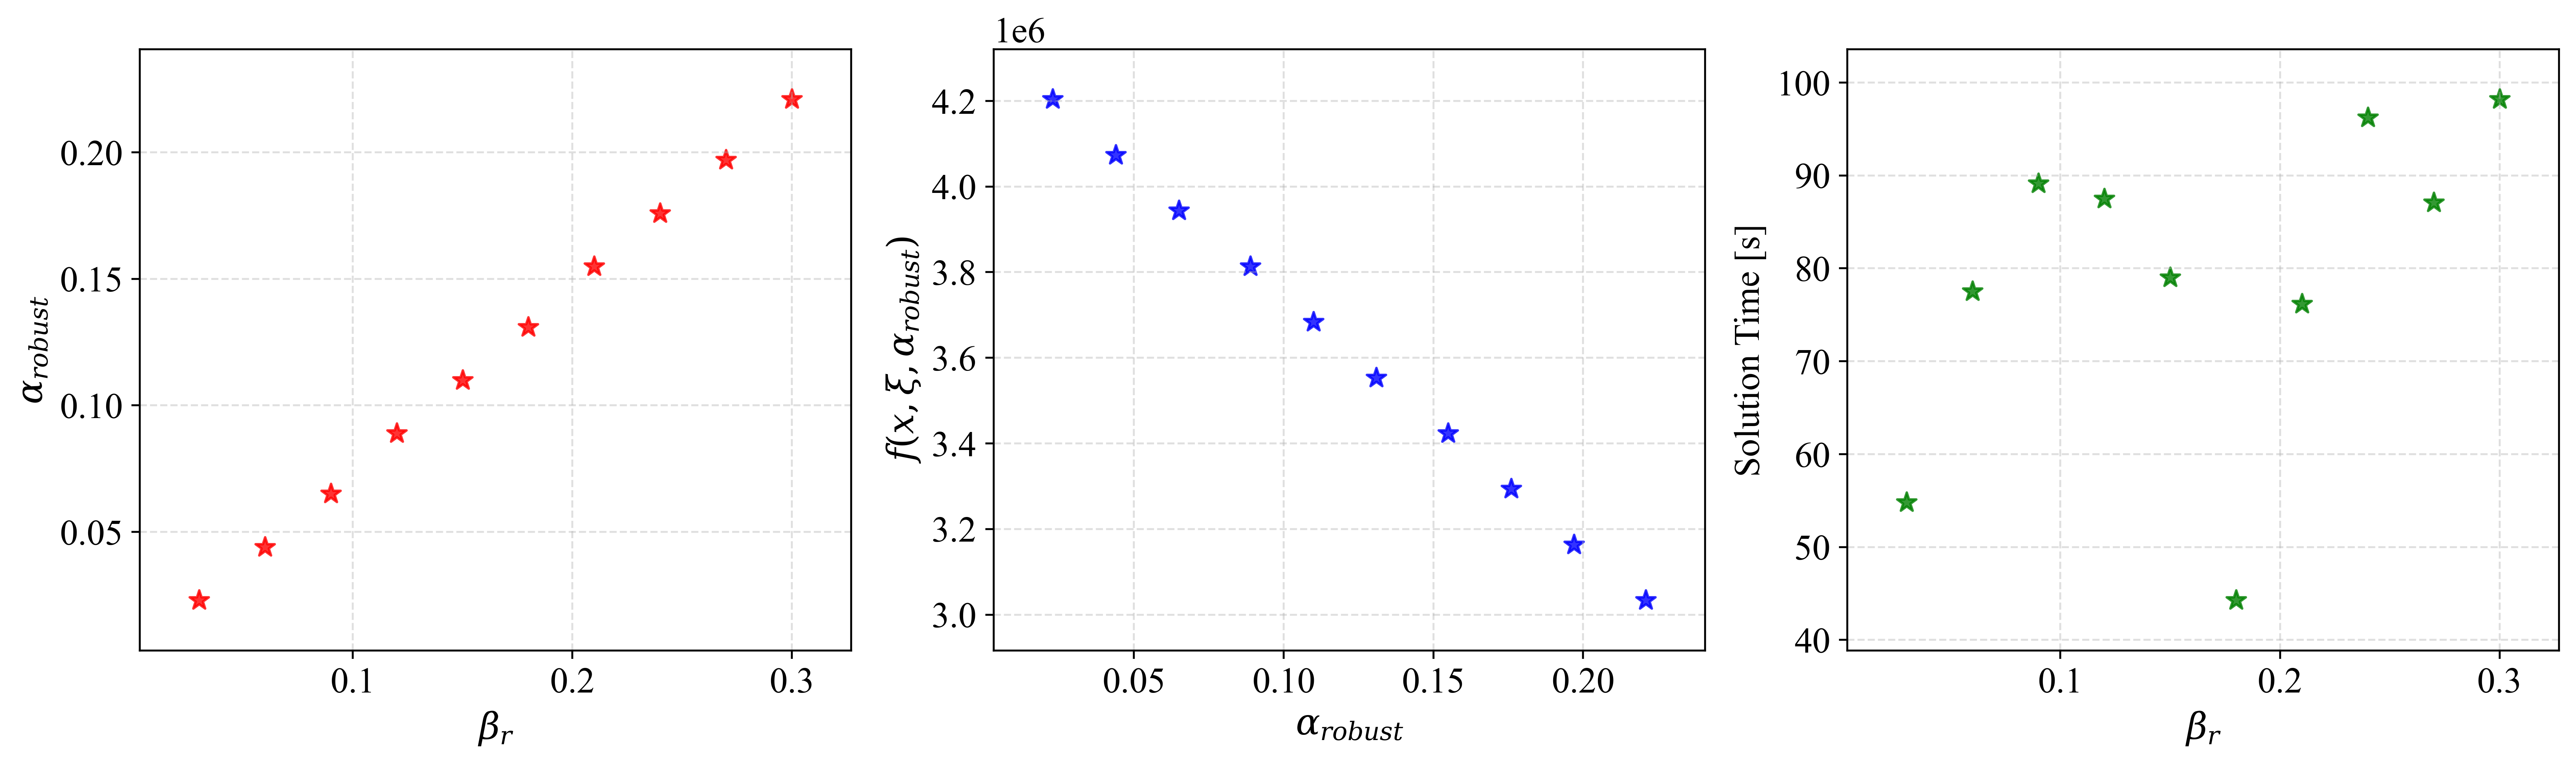

In [14]:
igdt_list = [all_alpha, all_beta, all_igdt_obj_list, all_solve_time]
case_fig.make_igdt_plot(igdt_list, save_flag = True, fig_size=(18,4.5))

In [15]:
scen = 20
all_obj_dicts1 = []
all_P_dicts = []
all_U_dicts = []
all_objVal = []
all_solve_time1 = []
all_alpha1 = []
all_reliable = []
all_reliable_array1 = []
all_beta1 = []
all_igdt_obj_list1 = []
grid_piece_list1 = []
case_dict['case'] = 7
start_time = time.time()
case_dict['beta'] = 0.1
case_dict['GRID_PIECE'] = 100
all_slack_dict = []
for i in range(scen):
    
    print("*"*30)
    print("iterion_grid_piece i :", i)
    print("iterion i :", i)
    print("iterion i :", i)
    print("*"*30)
    
    case_dict['GRID_PIECE'] = (i+1) * 10
    
    
    # Gurobi Optimization Model
    opt_bid_igdt = gurobi_MILP(f'opt bid{i}_{j}', vpp_list[0], model_dict, case_dict)
    opt_bid_igdt.set_igdt_params(base_obj, case_dict['beta'])
    sol, obj_dict, P_dict, U_dict, slack_dict = opt_bid_igdt.optimize(mip_gap, feas_tol)
    igdt_profit = sum(obj_dict['obj1'] - obj_dict['obj_risk_averse'] - obj_dict['obj2'] - obj_dict['obj3'] - sum(obj_dict['dg_cost']))
    all_igdt_obj_list1.append(igdt_profit)
    
    grid_piece_list1.append(case_dict['GRID_PIECE'])
    all_obj_dicts1.append(obj_dict) 
    all_P_dicts.append(P_dict)
    all_U_dicts.append(U_dict)
    all_objVal.append(opt_bid_igdt.m.objVal)
    all_solve_time1.append(opt_bid_igdt.opt_solve_time)
    all_alpha1.append(slack_dict['alpha'])
    all_beta1.append(case_dict['beta'])
    all_slack_dict.append(slack_dict)
end_time = time.time()
total_solution_time = end_time - start_time

******************************
iterion_grid_piece i : 0
iterion i : 0
iterion i : 0
******************************
Add Bid Constraint
start set_dro_obj_constriants
end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
start add_igdt_constraints
add_igdt_risk_averse_constraints sucessfully
End add_igdt_constarints
start add_igdt_constraints
add_igdt_risk_averse_constraints sucessfully
End add_igdt_constarints
Set parameter FeasibilityTol to value 0.0001
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 25293 rows, 56901 columns and 132874 nonzeros
Model fingerprint: 0x7d8a00bb
Model has 2 SOS constraints


     0     0    0.10252    0  349          -    0.10252      -     -   12s
     0     0    0.10221    0  331          -    0.10221      -     -   13s
     0     0    0.10201    0  339          -    0.10201      -     -   14s
     0     0    0.10087    0  333          -    0.10087      -     -   14s
     0     0    0.10087    0  329          -    0.10087      -     -   15s
     0     0    0.10087    0  325          -    0.10087      -     -   16s
     0     0    0.09428    0  289          -    0.09428      -     -   19s
     0     2    0.09428    0  289          -    0.09428      -     -   20s
   233   111    0.07020   32  110          -    0.09302      -  92.8   25s
  1278   494    0.07024   34   85          -    0.08462      -  37.8   30s
  2382   689 infeasible   75               -    0.08462      -  32.8   35s
  3554   730    0.07463   18  138          -    0.08462      -  29.0   40s
  4820   776 infeasible   62               -    0.08462      -  30.3   45s
  5876   910    0.07019  

* 4363   446             116       0.0766820    0.07670  0.02%  20.1   57s
H 4634   392                       0.0766873    0.07670  0.01%  20.2   59s
H 4662   392                       0.0767044    0.07670  0.00%  20.1   59s

Cutting planes:
  Learned: 21
  Gomory: 26
  Cover: 335
  Implied bound: 12082
  Clique: 389
  MIR: 351
  Flow cover: 985
  Flow path: 4
  Inf proof: 5
  Zero half: 1
  RLT: 114
  Relax-and-lift: 225
  BQP: 132
  PSD: 154

Explored 4734 nodes (130943 simplex iterations) in 59.40 seconds (182.60 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 0.0767044 0.0766678 
No other solutions better than 0.0767044

Optimal solution found (tolerance 1.00e-04)
Best objective 7.670436211278e-02, best bound 7.670436211278e-02, gap 0.0000%
Optimal Solution:
Optimization Duration Time: 59.42699909210205
******************************
iterion_grid_piece i : 3
iterion i : 3
iterion i : 3
******************************
Add Bid Constraint
start set_dro_o

iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
start add_igdt_constraints
add_igdt_risk_averse_constraints sucessfully
End add_igdt_constarints
start add_igdt_constraints
add_igdt_risk_averse_constraints sucessfully
End add_igdt_constarints
Set parameter FeasibilityTol to value 0.0001
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 27293 rows, 57941 columns and 150554 nonzeros
Model fingerprint: 0xc56b983d
Model has 2 SOS constraints
Model has 5000 general constraints
Variable types: 57699 continuous, 242 integer (242 binary)
Coefficient statistics:
  Matrix range     [6e-04, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e-01, 1e+07]
  RHS ran


Root relaxation: objective 1.832735e-01, 6795 iterations, 0.47 seconds (2.22 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.18327    0 1084          -    0.18327      -     -    5s
     0     0    0.18210    0 1069          -    0.18210      -     -    5s
     0     0    0.17884    0 1068          -    0.17884      -     -    5s
     0     0    0.17721    0 1070          -    0.17721      -     -    5s
     0     0    0.17554    0 1070          -    0.17554      -     -    5s
     0     0    0.17391    0 1064          -    0.17391      -     -    5s
     0     0    0.17252    0 1062          -    0.17252      -     -    6s
     0     0    0.17075    0 1064          -    0.17075      -     -    6s
     0     0    0.16924    0 1060          -    0.16924      -     -    6s
     0     0    0.16766    0 1061          -    0.16766      -     -    6s
     0  

     0     0    0.15686    0  995          -    0.15686      -     -    4s
     0     0    0.15545    0 1000          -    0.15545      -     -    4s
     0     0    0.15403    0  999          -    0.15403      -     -    4s
     0     0    0.15259    0  999          -    0.15259      -     -    4s
     0     0    0.15115    0  999          -    0.15115      -     -    4s
     0     0    0.14729    0 1004          -    0.14729      -     -    5s
     0     0    0.14599    0 1000          -    0.14599      -     -    6s
     0     0    0.14477    0  996          -    0.14477      -     -    6s
     0     0    0.14356    0  997          -    0.14356      -     -    6s
     0     0    0.13585    0  992          -    0.13585      -     -    6s
     0     0    0.13473    0  982          -    0.13473      -     -    6s
     0     0    0.13343    0  982          -    0.13343      -     -    6s
     0     0    0.13066    0  980          -    0.13066      -     -    6s
     0     0    0.12898  

     0     0    0.14044    0  986          -    0.14044      -     -   11s
     0     0    0.13926    0  987          -    0.13926      -     -   12s
     0     0    0.13810    0  988          -    0.13810      -     -   12s
     0     0    0.13710    0  990          -    0.13710      -     -   12s
     0     0    0.13333    0  989          -    0.13333      -     -   12s
     0     0    0.13132    0  893          -    0.13132      -     -   13s
     0     0    0.11940    0  792          -    0.11940      -     -   13s
     0     0    0.11922    0  793          -    0.11922      -     -   13s
     0     0    0.11895    0  791          -    0.11895      -     -   14s
     0     0    0.11886    0  791          -    0.11886      -     -   14s
     0     0    0.11876    0  789          -    0.11876      -     -   14s
     0     0    0.11302    0  630          -    0.11302      -     -   15s
     0     0    0.10809    0  560          -    0.10809      -     -   16s
     0     0    0.10791  

     0     0    0.14589    0 1021          -    0.14589      -     -    7s
     0     0    0.14499    0 1017          -    0.14499      -     -    7s
     0     0    0.13271    0 1022          -    0.13271      -     -    7s
     0     0    0.12477    0  808          -    0.12477      -     -    8s
     0     0    0.11938    0  791          -    0.11938      -     -    9s
     0     0    0.11874    0  788          -    0.11874      -     -    9s
     0     0    0.11848    0  789          -    0.11848      -     -    9s
     0     0    0.11828    0  793          -    0.11828      -     -    9s
     0     0    0.11815    0  790          -    0.11815      -     -    9s
     0     0    0.11350    0  746          -    0.11350      -     -   10s
     0     0    0.11085    0  740          -    0.11085      -     -   11s
     0     0    0.11085    0  642          -    0.11085      -     -   12s
     0     0    0.11085    0  625          -    0.11085      -     -   13s
     0     0    0.10950  

     0     0    0.16830    0 1019          -    0.16830      -     -   10s
     0     0    0.16620    0 1020          -    0.16620      -     -   10s
     0     0    0.16520    0 1020          -    0.16520      -     -   10s
     0     0    0.16159    0 1018          -    0.16159      -     -   10s
     0     0    0.16068    0 1020          -    0.16068      -     -   10s
     0     0    0.15862    0 1020          -    0.15862      -     -   11s
     0     0    0.15774    0 1018          -    0.15774      -     -   11s
     0     0    0.15677    0 1018          -    0.15677      -     -   11s
     0     0    0.15475    0 1017          -    0.15475      -     -   11s
     0     0    0.15285    0 1018          -    0.15285      -     -   11s
     0     0    0.15092    0  966          -    0.15092      -     -   12s
     0     0    0.14986    0  962          -    0.14986      -     -   12s
     0     0    0.14875    0  964          -    0.14875      -     -   12s
     0     0    0.14673  

add_igdt_risk_averse_constraints sucessfully
End add_igdt_constarints
Set parameter FeasibilityTol to value 0.0001
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 30293 rows, 59501 columns and 177074 nonzeros
Model fingerprint: 0x2a187ef9
Model has 2 SOS constraints
Model has 5240 general constraints
Variable types: 59199 continuous, 302 integer (302 binary)
Coefficient statistics:
  Matrix range     [6e-04, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e-01, 1e+07]
  RHS range        [7e-02, 4e+06]
  GenCon rhs range [3e-03, 3e-01]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 6867 rows and 33288 columns
Presolve time: 0.68s
Presolved: 23426 rows, 26213 columns, 97277 nonzeros
Variable types: 24719 continuous, 1494 integer (1494 binary)

Root relaxation: objective 1.82502

end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
start add_igdt_constraints
add_igdt_risk_averse_constraints sucessfully
End add_igdt_constarints
start add_igdt_constraints
add_igdt_risk_averse_constraints sucessfully
End add_igdt_constarints
Set parameter FeasibilityTol to value 0.0001
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 30793 rows, 59761 columns and 181494 nonzeros
Model fingerprint: 0xed836b05
Model has 2 SOS constraints
Model has 5280 general constraints
Variable types: 59449 continuous, 312 integer (312 binary)
Coefficient statistics:
  Matrix range     [6e-04, 3e+05]
  Objective 

add_igdt_risk_averse_constraints sucessfully
End add_igdt_constarints
Set parameter FeasibilityTol to value 0.0001
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 31293 rows, 60021 columns and 185914 nonzeros
Model fingerprint: 0x11c43fb8
Model has 2 SOS constraints
Model has 5320 general constraints
Variable types: 59699 continuous, 322 integer (322 binary)
Coefficient statistics:
  Matrix range     [6e-04, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e-01, 1e+07]
  RHS range        [7e-02, 4e+06]
  GenCon rhs range [2e-03, 3e-01]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 7367 rows and 33288 columns
Presolve time: 0.69s
Presolved: 23926 rows, 26733 columns, 99317 nonzeros
Variable types: 25219 continuous, 1514 integer (1514 binary)

Root relaxation: objective 1.82258

     0     0    0.08561    0  288          -    0.08561      -     -   34s
     0     0    0.08532    0  275          -    0.08532      -     -   35s
     0     0    0.08507    0  271          -    0.08507      -     -   35s
     0     0    0.08499    0  289          -    0.08499      -     -   36s
     0     0    0.08499    0  284          -    0.08499      -     -   36s
     0     0    0.08499    0  270          -    0.08499      -     -   37s
     0     0    0.08278    0  262          -    0.08278      -     -   38s
     0     2    0.08278    0  262          -    0.08278      -     -   40s
   547   257    0.06037   49  133          -    0.07771      -  60.2   45s
H 1016   415                       0.0177576    0.07477   321%  58.0   47s
* 1018   415              86       0.0177576    0.07477   321%  57.9   47s
  1563   504    0.02467   34  113    0.01776    0.07477   321%  51.0   50s
  2699   876    0.07175   63   43    0.01776    0.07477   321%  45.2   55s
  2996   961    0.04225  

     0     0    0.10896    0  549          -    0.10896      -     -   16s
     0     0    0.10819    0  524          -    0.10819      -     -   18s
     0     0    0.10739    0  523          -    0.10739      -     -   18s
     0     0    0.10651    0  467          -    0.10651      -     -   19s
     0     0    0.10601    0  457          -    0.10601      -     -   20s
     0     0    0.10495    0  430          -    0.10495      -     -   21s
     0     0    0.10464    0  430          -    0.10464      -     -   21s
     0     0    0.10295    0  385          -    0.10295      -     -   23s
     0     0    0.10289    0  387          -    0.10289      -     -   23s
     0     0    0.09981    0  336          -    0.09981      -     -   24s
     0     0    0.09981    0  334          -    0.09981      -     -   25s
     0     0    0.09962    0  322          -    0.09962      -     -   26s
     0     0    0.09721    0  286          -    0.09721      -     -   29s
     0     0    0.09721  

     0     0    0.16659    0 1030          -    0.16659      -     -    5s
     0     0    0.16595    0 1030          -    0.16595      -     -    5s
     0     0    0.16530    0 1030          -    0.16530      -     -    5s
     0     0    0.15501    0 1008          -    0.15501      -     -    8s
     0     0    0.15459    0 1007          -    0.15459      -     -    8s
     0     0    0.15412    0 1007          -    0.15412      -     -    8s
     0     0    0.15365    0 1008          -    0.15365      -     -    9s
     0     0    0.15299    0 1008          -    0.15299      -     -    9s
     0     0    0.15258    0 1009          -    0.15258      -     -    9s
     0     0    0.15217    0 1005          -    0.15217      -     -    9s
     0     0    0.15181    0 1003          -    0.15181      -     -    9s
     0     0    0.15144    0 1005          -    0.15144      -     -    9s
     0     0    0.15094    0 1003          -    0.15094      -     -    9s
     0     0    0.15049  

Variable types: 60449 continuous, 352 integer (352 binary)
Coefficient statistics:
  Matrix range     [6e-04, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e-01, 1e+07]
  RHS range        [7e-02, 4e+06]
  GenCon rhs range [2e-03, 3e-01]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 8116 rows and 33288 columns
Presolve time: 0.72s
Presolved: 24677 rows, 27513 columns, 102379 nonzeros
Variable types: 25969 continuous, 1544 integer (1544 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.11s

Solved with dual simplex

Root relaxation: objective 1.816452e-01, 8299 iterations, 1.10 seconds (3.72 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.18165    0 1089          -    0.18165      -     -    7s
     0     0    0.18087    0 1074          -    0.18087      -     -   

     0     0    0.08465    0  275          -    0.08465      -     -   48s
     0     0    0.08465    0  275          -    0.08465      -     -   48s
     0     0    0.08465    0  279          -    0.08465      -     -   48s
     0     0    0.08465    0  274          -    0.08465      -     -   49s
     0     0    0.08414    0  236          -    0.08414      -     -   51s
     0     2    0.08414    0  236          -    0.08414      -     -   52s
    55    17    0.07614    8  166          -    0.08341      -   382   55s
   570   377    0.06376   72  101          -    0.08273      -   125   60s
  1221   765    0.06695   29  118          -    0.08236      -   101   65s
  1478   858    0.01628   72  193          -    0.08126      -  93.9   70s
  1488   864    0.06754   28  203          -    0.08033      -  93.3   75s
  1495   869    0.07046   26  182          -    0.08000      -  92.9   80s
H 1502   829                       0.0163032    0.07956   388%  92.4   85s
H 1506   789             

     0     0    0.14102    0  872          -    0.14102      -     -   10s
     0     0    0.14059    0  874          -    0.14059      -     -   10s
     0     0    0.13903    0  877          -    0.13903      -     -   11s
     0     0    0.13855    0  878          -    0.13855      -     -   11s
     0     0    0.13804    0  878          -    0.13804      -     -   11s
     0     0    0.13701    0  878          -    0.13701      -     -   11s
     0     0    0.13597    0  874          -    0.13597      -     -   11s
     0     0    0.13494    0  871          -    0.13494      -     -   11s
     0     0    0.13474    0  877          -    0.13474      -     -   11s
     0     0    0.12547    0  720          -    0.12547      -     -   13s
     0     0    0.12360    0  720          -    0.12360      -     -   14s
     0     0    0.11571    0  721          -    0.11571      -     -   14s
     0     0    0.11414    0  718          -    0.11414      -     -   14s
     0     0    0.11306  


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.18107    0 1091          -    0.18107      -     -    3s
     0     0    0.18043    0 1093          -    0.18043      -     -    3s
     0     0    0.17999    0 1092          -    0.17999      -     -    3s
     0     0    0.17999    0 1088          -    0.17999      -     -    3s
     0     0    0.17740    0 1082          -    0.17740      -     -    3s
     0     0    0.17686    0 1081          -    0.17686      -     -    3s
     0     0    0.17630    0 1081          -    0.17630      -     -    3s
     0     0    0.17590    0 1083          -    0.17590      -     -    3s
     0     0    0.17414    0 1081          -    0.17414      -     -    3s
     0     0    0.17350    0 1081          -    0.17350      -     -    3s
     0     0    0.17320    0 1077          -    0.17320      -     -    3s
     0     0    0.17203

  1419   703    0.07136   69  103          -    0.07676      -  63.6   60s
H 2994   759                       0.0228217    0.07512   229%  42.1   64s
  3137   747     cutoff   93         0.02282    0.07512   229%  41.0   65s
* 4244   880              89       0.0228217    0.07441   226%  40.1   68s
  4536   970    0.06972   73  278    0.02282    0.07441   226%  39.3   71s
  4541   973    0.04781   82  155    0.02282    0.07440   226%  39.3   75s
H 4550   929                       0.0228244    0.07436   226%  39.2   79s
  4553   931    0.07070   16  119    0.02282    0.07436   226%  39.2   80s
H 4555   886                       0.0361216    0.07432   106%  39.2   80s
H 4564   847                       0.0411231    0.07410  80.2%  39.1   84s
  4566   848    0.06773   77   66    0.04112    0.07410  80.2%  39.1   85s
H 4685   850                       0.0694206    0.07331  5.61%  43.9   89s
* 4757   792              33       0.0694414    0.07331  5.58%  43.7   89s
  4762   800    0.07274  

     0     0    0.11369    0  620          -    0.11369      -     -   18s
     0     0    0.11369    0  619          -    0.11369      -     -   19s
     0     0    0.11234    0  609          -    0.11234      -     -   19s
     0     0    0.11061    0  557          -    0.11061      -     -   20s
     0     0    0.11059    0  558          -    0.11059      -     -   20s
     0     0    0.10981    0  530          -    0.10981      -     -   21s
     0     0    0.10759    0  494          -    0.10759      -     -   22s
     0     0    0.10759    0  498          -    0.10759      -     -   23s
     0     0    0.10716    0  477          -    0.10716      -     -   24s
     0     0    0.10454    0  453          -    0.10454      -     -   26s
     0     0    0.10454    0  640          -    0.10454      -     -   29s
     0     0    0.10454    0  638          -    0.10454      -     -   29s
     0     0    0.10454    0  631          -    0.10454      -     -   29s
     0     0    0.10454  

     0     0    0.07274    0   64    0.06892    0.07274  5.54%     -   64s
     0     0    0.07274    0   65    0.06892    0.07274  5.54%     -   64s
     0     0    0.07274    0   74    0.06892    0.07274  5.54%     -   64s
     0     0    0.07274    0   73    0.06892    0.07274  5.54%     -   64s
     0     0    0.07274    0   71    0.06892    0.07274  5.54%     -   64s
     0     0    0.07274    0   67    0.06892    0.07274  5.54%     -   64s
     0     0    0.07274    0   65    0.06892    0.07274  5.54%     -   65s
     0     0    0.07274    0   67    0.06892    0.07274  5.54%     -   65s
     0     0    0.07264    0   54    0.06892    0.07264  5.40%     -   65s
     0     0    0.07264    0   51    0.06892    0.07264  5.40%     -   65s
     0     0    0.07264    0   51    0.06892    0.07264  5.40%     -   65s
     0     1    0.07264    0   50    0.06892    0.07264  5.40%     -   65s
*  327   211              31       0.0727540    0.07275  0.00%  65.0   67s

Cutting planes:
  Learne

     0     0    0.10791    0  543          -    0.10791      -     -   19s
     0     0    0.10791    0  542          -    0.10791      -     -   19s
     0     0    0.10791    0  541          -    0.10791      -     -   19s
     0     0    0.10754    0  534          -    0.10754      -     -   20s
     0     0    0.10753    0  534          -    0.10753      -     -   20s
     0     0    0.10753    0  535          -    0.10753      -     -   20s
     0     0    0.10753    0  534          -    0.10753      -     -   20s
     0     0    0.10752    0  534          -    0.10752      -     -   20s
     0     0    0.10623    0  513          -    0.10623      -     -   21s
     0     0    0.10623    0  517          -    0.10623      -     -   22s
     0     0    0.10500    0  483          -    0.10500      -     -   23s
     0     0    0.10500    0  486          -    0.10500      -     -   24s
     0     0    0.10435    0  466          -    0.10435      -     -   25s
     0     0    0.10435  

save the fig at location : C:\Users\user\OneDrive\1. CODE\IGDT-DRO-optimal-bidding-of-virtual-power-plant


<Figure size 9000x2250 with 0 Axes>

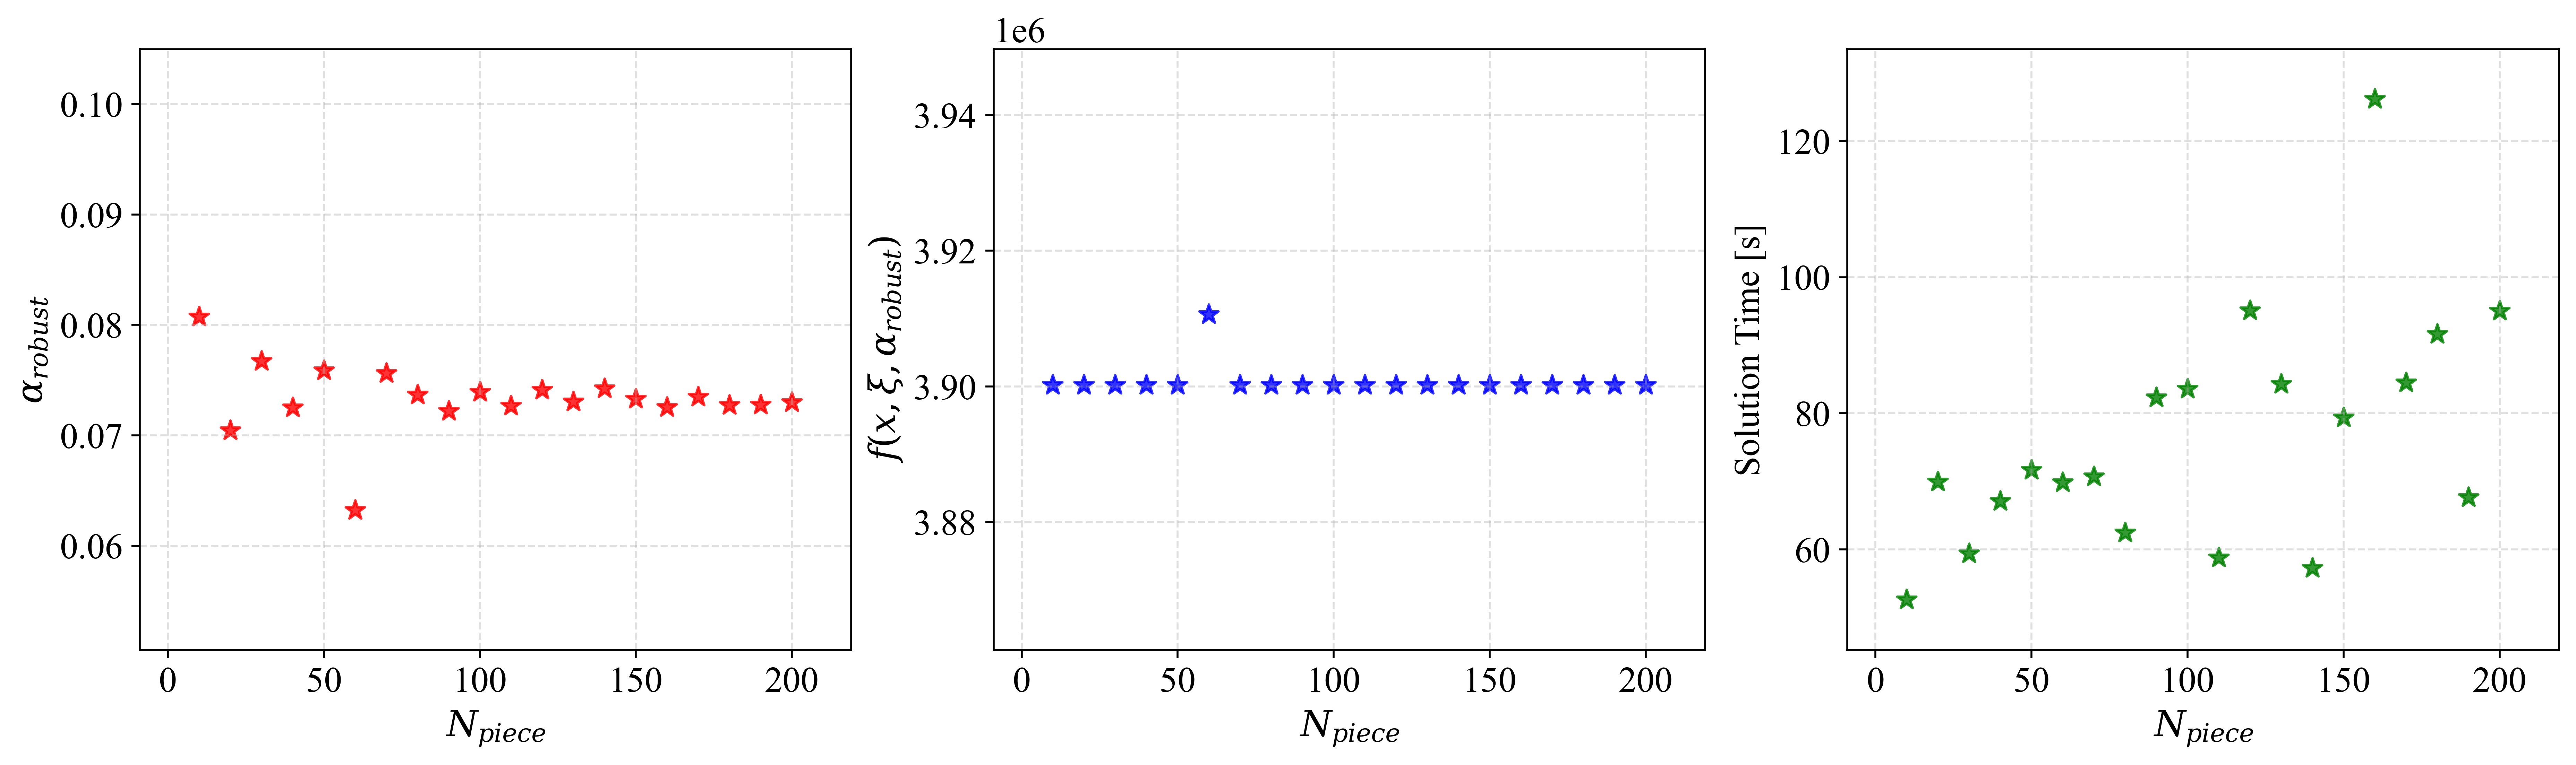

In [16]:
igdt_list = [all_alpha1, grid_piece_list1, all_igdt_obj_list1, all_solve_time1]
case_fig.make_igdt_gridpiece_plot(igdt_list, save_flag = True, fig_size=(18,4.5))

In [17]:
all_igdt_obj_list1

[3900178.5880384073,
 3900178.588038371,
 3900178.588038374,
 3900178.588038401,
 3900178.588038404,
 3910601.0694342037,
 3900178.5880383817,
 3900178.5880384054,
 3900178.588038386,
 3900178.5880383747,
 3900178.5880383914,
 3900178.588038374,
 3900178.5880384,
 3900178.5880383723,
 3900178.588038368,
 3900178.588038413,
 3900178.5880383723,
 3900178.5880384,
 3900178.5880384077,
 3900178.588038404]

Text(0, 0.5, 'Solution Time [s]')

<Figure size 9000x2250 with 0 Axes>

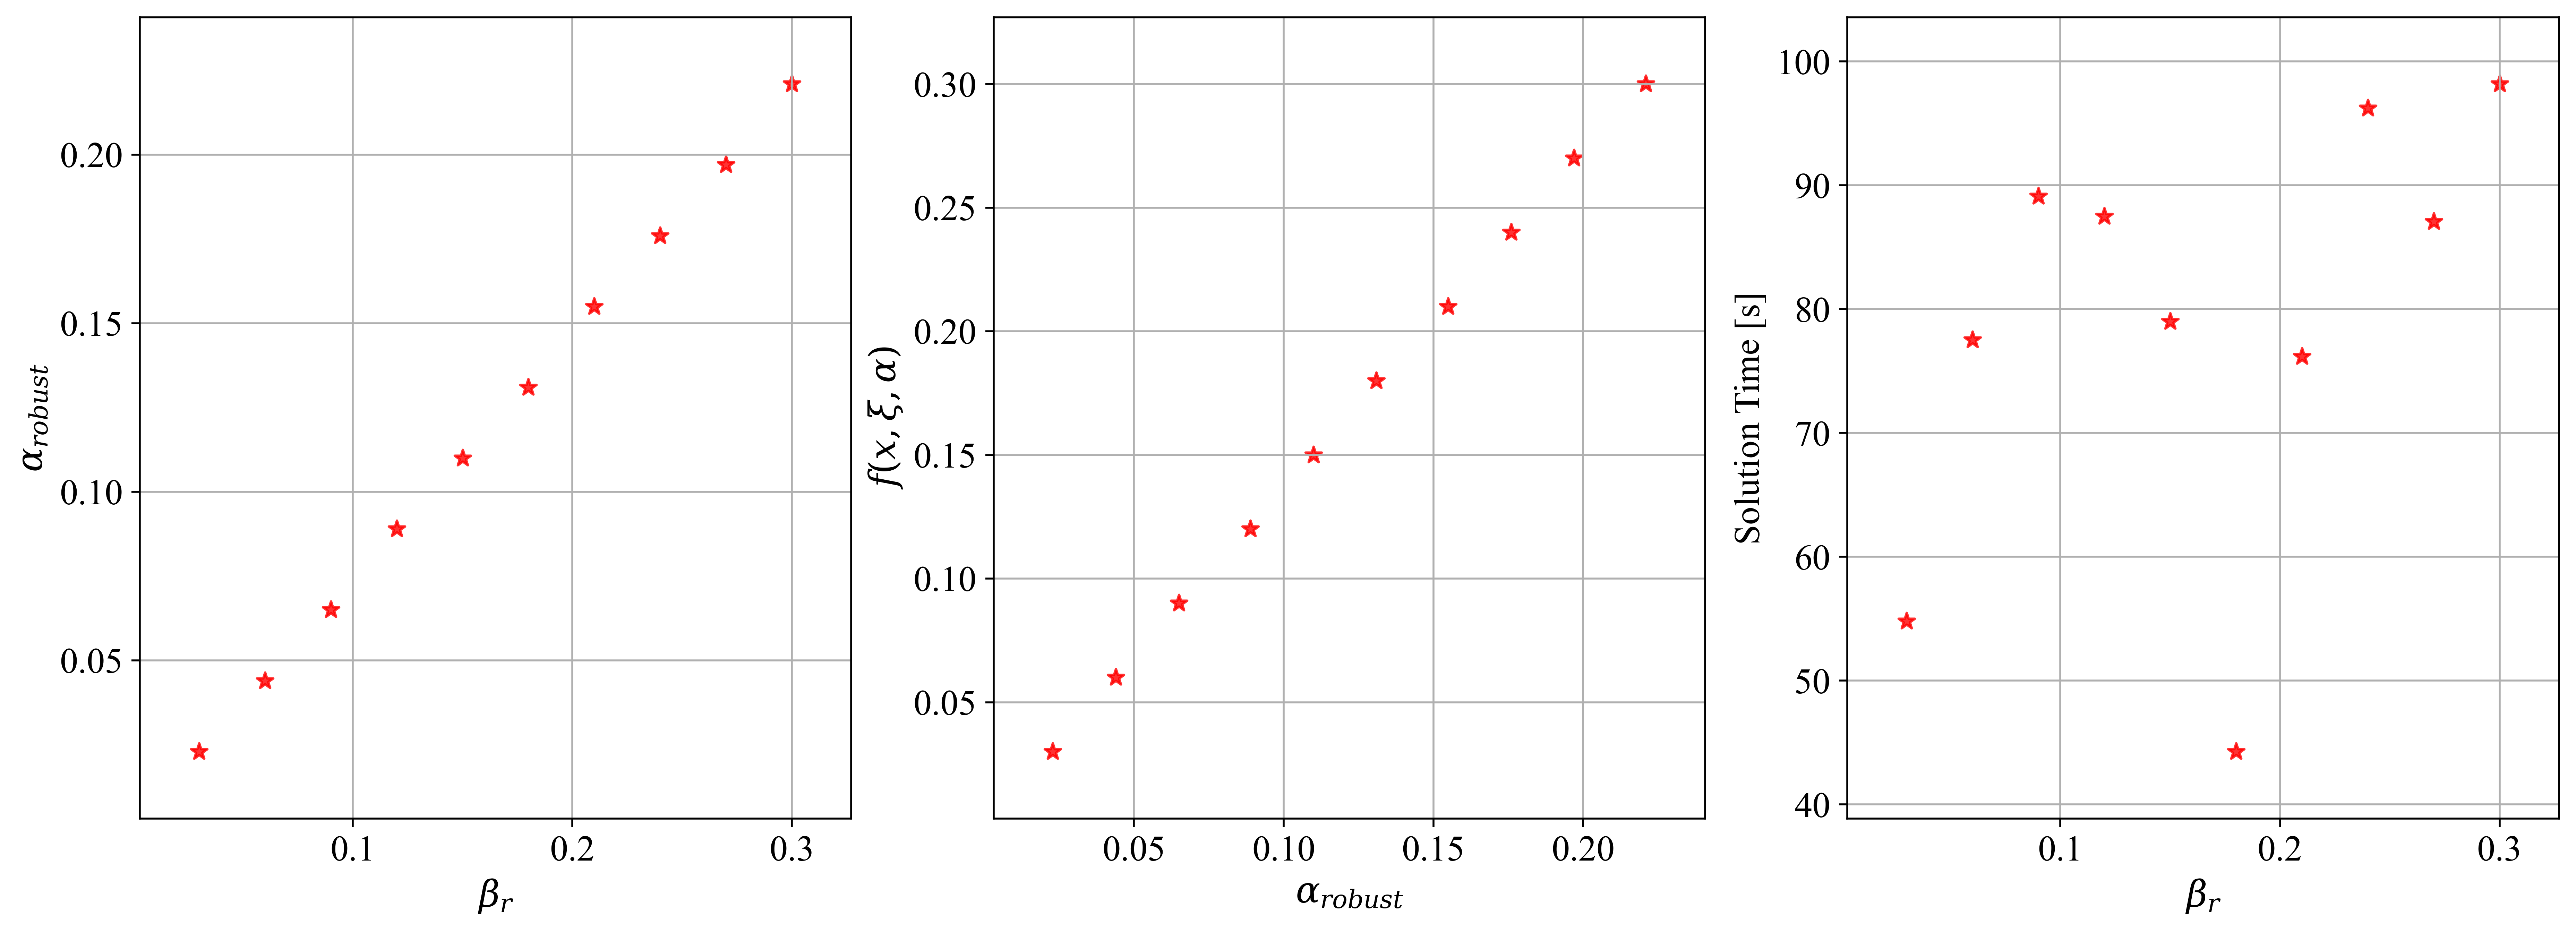

In [18]:
plt.figure()
plt.rcParams["figure.figsize"] = (18,6)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# Bid Graph
ax1 = plt.subplot(131)
ax1.scatter(all_beta,all_alpha, marker = '*', s=50, color='red', alpha = 0.8)
ax1.set_xlabel(r"$\beta_r$")
ax1.set_ylabel(r"$\alpha_{robust}$")


ax2 = plt.subplot(132)
ax2.scatter(all_alpha,all_beta, marker = '*', s=50, color='red', alpha = 0.8)
ax2.set_xlabel(r"$\alpha_{robust}$")
ax2.set_ylabel(r"$f(x,\xi,\alpha)$")        

ax3 = plt.subplot(133)
ax3.scatter(all_beta,all_solve_time, marker = '*', s=50, color='red', alpha = 0.8)
ax3.set_xlabel(r"$\beta_r$")
ax3.set_ylabel("Solution Time [s]") 

In [19]:
total_solution_time

1715.5900239944458

In [20]:
all_slack_dict[3]['alpha_dx']

array([ 0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
        0.000000,  0.000000,  0.000000,  0.005023,  0.000000,  0.000000,
        0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
        0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
        0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
        0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
        0.000000,  0.000000,  0.000000,  0.000000])

In [21]:
all_slack_dict[2]['alpha_dx']

array([ 0.000043,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
        0.000000,  0.006661,  0.000000,  0.000000,  0.000000,  0.000000,
        0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
        0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
        0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000])

In [22]:
all_slack_dict[1]['alpha_dx']

array([ 0.000065,  0.000000,  0.000000,  0.000000,  0.010382,  0.000000,
        0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
        0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
        0.000000,  0.000000])

In [23]:
all_alpha1

[0.08074648761059809,
 0.07044707507163149,
 0.07670436211278354,
 0.07252284369792564,
 0.07586667640111774,
 0.06322851487605428,
 0.07562572708923251,
 0.07366706024347884,
 0.0721850231814492,
 0.07393711330203918,
 0.07266979753161305,
 0.07411058618324577,
 0.07303498606535706,
 0.07423838845153913,
 0.0733003905048873,
 0.07253502509035571,
 0.07348973557329738,
 0.0727417305714138,
 0.07275399228174763,
 0.07296633514413313]